In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing the required preprocessing and model selection modules from scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Importing the ensemble, neighbors, linear model, and tree-based classifiers from scikit-learn
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Importing performance metrics from scikit-learn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support

# Ignoring warning messages to keep the notebook clean
import warnings
warnings.filterwarnings('ignore')

### Preprocessing

1. Reading in the data and transposing it so that the categories are in columns rather than rows.
2. Encoding the categorical columns.
3. Checking for NaN values and using KNN Imputation to fill them (https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/).
4. Scaling all the columns in the dataset.
5. Combining the technical replicates 'left' and 'right' by taking the average.

In [173]:
# Read in the xls data
df_left = pd.read_excel('GSE27293_rawdata.xls', sheet_name='left', header=None)
df_right = pd.read_excel('GSE27293_rawdata.xls', sheet_name='right', header=None)

# Transposing the data so that the categories are in columns rather than rows.
df_left = df_left.transpose()
df_right = df_right.transpose()
df_left.columns = df_left.iloc[0] # Setting the column names to the first row
df_right.columns = df_right.iloc[0]
df_left = df_left.drop(df_left.index[0]) # Dropping the first row, as its a duplicate of the column names
df_right = df_right.drop(df_right.index[0])
df_right.columns = df_right.columns.astype(str) # Converting the column names to strings
df_left.columns = df_left.columns.astype(str)


In [174]:
# Label Encoding the 'label' column
label_encoder = LabelEncoder()
df_left['label'] = label_encoder.fit_transform(df_left['label'])
df_right['label'] = label_encoder.fit_transform(df_right['label'])

In [175]:
# Checking for null values
print("Null values in left data: " + str(df_left.isnull().sum().sum()))
print("Null values in right data: " + str(df_right.isnull().sum().sum()))

Null values in left data: 1918
Null values in right data: 1918


In [176]:
# Drop the ID column before imputation
id_left = df_left['ID']
id_right = df_right['ID']
df_left = df_left.drop('ID', axis=1)
df_right = df_right.drop('ID', axis=1)

# Perform KNN imputation
imputer = KNNImputer(n_neighbors=2)
df_left = pd.DataFrame(imputer.fit_transform(df_left), columns=df_left.columns)
df_right = pd.DataFrame(imputer.fit_transform(df_right), columns=df_right.columns)

# Add the ID column back
df_left['ID'] = id_left
df_right['ID'] = id_right

# Dropping any rows wich still have null values (incase they were not imputed)
df_left = df_left.dropna()
df_right = df_right.dropna()

if df_left.isnull().sum().sum() == 0 and df_right.isnull().sum().sum() == 0:
    print("No null values in data")
else:
    print("Null values in left data: " + str(df_left.isnull().sum().sum()))
    print("Null values in right data: " + str(df_right.isnull().sum().sum()))

No null values in data


In [177]:
df_average = pd.DataFrame()
df_average['ID'] = df_left['ID']
df_average['label'] = df_left['label']

for i in range(1, len(df_left.columns)-1):
    df_average[df_left.columns[i]] = (df_left.iloc[:, i] + df_right.iloc[:, i]) / 2

# Saving Feature column names in a list (All columns except the ID and label columns)
feature_cols = df_average.columns
feature_cols = feature_cols.drop('ID')
feature_cols = feature_cols.drop('label')

# Scaling all the feature columns
scaler = StandardScaler()
df_average[feature_cols] = scaler.fit_transform(df_average[feature_cols])

In [178]:
df_average

,ID,label,TCR a/b,TCR g/d,1a,2,3,4,5,7,...,mIgG1 50,mIgG 2a500,mIgG 2a200,mIgG 2a50,mIgG 2b500,mIgG 2b200,mIgG3 500,mIgM 500,mIgM 200,mIgM 50
1,X120571,1.0,1.398132,-0.034405,-0.123936,0.923793,0.090607,0.900269,1.106923,1.221352,...,0.348068,1.643535,1.153839,0.068100,-0.154414,0.176554,2.158845,-0.219046,-0.219564,0.087864
2,X120664,1.0,-1.169596,-0.440419,-0.398743,-0.512927,-0.047225,-1.242304,-0.049575,-0.616968,...,-0.403407,-0.408805,-0.542215,-0.515366,-0.288721,-0.425354,-0.472939,-0.390700,-0.361668,-0.473861
3,X120554,1.0,0.707311,0.733600,2.941228,0.274146,0.377522,0.527746,0.025075,0.204961,...,1.811335,-0.137142,0.585845,0.394289,0.838871,0.189852,2.745749,0.127628,0.260724,0.375190
4,X121995,1.0,-0.589307,-0.426029,-0.538671,-1.298864,-0.948758,-0.771570,-1.052179,-0.912552,...,-0.371166,-0.410412,-0.553066,-0.485963,-0.277843,-0.437998,-0.331662,-0.311161,-0.313198,-0.399826
5,X87355,1.0,-1.001010,-0.426456,-0.398953,-1.746348,-1.431170,-1.529034,-1.594251,-1.834305,...,-0.425418,-0.414029,-0.553066,-0.515366,-0.254830,-0.469172,-0.464866,-0.379008,0.226988,-0.368097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,X120198,0.0,0.779050,-0.323806,-0.116572,0.315033,0.262194,0.866403,0.340901,0.522583,...,0.053244,-0.327929,-0.158892,-0.495381,-0.098557,-0.090718,-0.076557,-0.340390,-0.296950,-0.359577
80,X121929,0.0,0.363229,0.091588,-0.011783,0.143535,0.450658,0.181186,0.462638,0.018276,...,-0.443089,-0.414029,-0.514254,-0.512609,-0.288721,-0.456528,-0.468095,-0.405757,-0.357675,-0.472098
81,X120013,0.0,-1.203340,-0.452784,-0.521838,-0.699189,-0.750449,-1.135062,-0.904028,-0.338238,...,-0.442469,-0.411719,-0.489422,0.433340,-0.288721,0.095893,0.201960,-0.361471,-0.361668,-0.459465
82,X120677,0.0,-0.605249,-0.251323,-0.560134,-0.328936,-0.404463,-0.253424,-0.081731,-0.268232,...,-0.211198,3.594603,4.204567,-0.267738,-0.263408,-0.470698,-0.442666,1.291473,-0.306451,-0.455058


### Exploratory Data Analysis

Performing some Exploratory Data Analysis & checking correlation between the features columns and label

In [179]:
df_average.describe()

,label,TCR a/b,TCR g/d,1a,2,3,4,5,7,8,...,mIgG1 50,mIgG 2a500,mIgG 2a200,mIgG 2a50,mIgG 2b500,mIgG 2b200,mIgG3 500,mIgM 500,mIgM 200,mIgM 50
count,83.000000,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,...,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01,8.300000e+01
mean,1.493976,-3.477807e-17,-6.153043e-17,4.079735e-17,-1.367715e-16,-2.875879e-16,-3.745331e-17,5.918960e-17,-2.467905e-16,1.585077e-16,...,6.754971e-17,8.426994e-17,-2.407713e-17,7.624423e-17,6.086162e-17,-1.003214e-17,-9.363327e-18,6.286805e-17,-1.872665e-17,6.086162e-17
std,1.108432,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,...,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00,1.006079e+00
min,0.000000,-1.204058e+00,-4.527841e-01,-5.601337e-01,-2.036077e+00,-1.738015e+00,-1.889704e+00,-1.872637e+00,-1.998690e+00,-1.386968e+00,...,-4.430889e-01,-4.140293e-01,-5.530661e-01,-5.153656e-01,-2.887210e-01,-4.720064e-01,-4.729392e-01,-4.082370e-01,-3.616677e-01,-4.738607e-01
25%,0.000000,-8.269758e-01,-4.194204e-01,-4.964822e-01,-6.662525e-01,-8.053006e-01,-7.241579e-01,-8.586634e-01,-6.383592e-01,-7.389088e-01,...,-4.230930e-01,-4.029779e-01,-5.369986e-01,-5.121497e-01,-2.810852e-01,-4.612152e-01,-4.392346e-01,-3.907881e-01,-3.496881e-01,-4.619622e-01
50%,2.000000,-2.199834e-01,-3.346787e-01,-3.537133e-01,8.901931e-02,-2.385019e-01,-4.345654e-02,-7.024690e-02,1.827637e-02,-2.607751e-01,...,-3.683755e-01,-3.355646e-01,-3.923916e-01,-4.439256e-01,-2.562949e-01,-3.828430e-01,-3.712199e-01,-3.379102e-01,-2.710629e-01,-3.874867e-01
75%,2.000000,6.647987e-01,4.980991e-03,-5.260459e-03,7.875038e-01,7.973472e-01,8.889802e-01,7.968390e-01,6.924136e-01,5.084345e-01,...,1.867743e-02,-1.981760e-01,-5.312238e-03,1.618492e-02,-1.441633e-01,1.302282e-01,-1.909911e-01,-1.183385e-01,-5.205538e-02,-2.215985e-02
max,3.000000,2.567213e+00,6.670849e+00,6.215338e+00,1.809676e+00,2.048383e+00,1.882375e+00,1.922328e+00,1.843632e+00,2.891236e+00,...,7.232866e+00,5.945531e+00,4.903605e+00,4.584212e+00,8.539551e+00,6.133499e+00,4.613025e+00,6.305575e+00,6.839900e+00,6.283290e+00


In [180]:
# Checking Correlation between features and label
df_average[feature_cols].corrwith(df_average.label).sort_values(ascending=False)

15         0.274982
66c        0.185185
36         0.167975
41         0.167474
10 ALB1    0.161388
             ...   
122       -0.348709
2         -0.364057
5         -0.371084
56        -0.383415
7         -0.385609
Length: 160, dtype: float64

### Model Training

Splitting the data into training and testing sets, 80% training and 20% test.

In [181]:
# Splitting the data into training and testing sets
X = df_average[feature_cols]
y = df_average.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% test

Creating four distinct classifier models: KNN (K-Nearest Neighbors classifier), Random Forest, Logistic Regression, and Decision Tree classifier. The scores for each model are stored in a list, which will serve as weights for a Voting Classifier model.

In [182]:
weights = [] # List to store the weights of each classifier

# Creating the classifiers, fitting them to the training data, predicting the test data and calculating the accuracy score. Then appending the accuracy score to the weights list.
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
weights.append(accuracy_score(y_test, y_pred))

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
weights.append(accuracy_score(y_test, y_pred))

lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
weights.append(accuracy_score(y_test, y_pred))

dt = DecisionTreeClassifier(random_state=42, max_depth=1000)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
weights.append(accuracy_score(y_test, y_pred))

Created a voting classifier model using four different models: K-Nearest Neighbors (KNN), Random Forest, Logistic Regression, and Decision Tree. Each model is assigned a specific weight based on its accuracy. We use a "hard" voting scheme, which means that it selects the class label that receives the majority of votes from the individual models.

In [183]:
# Creating the model, we will be using a voting classifier from the 4 different models, while using there accuracy as weights.
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(n_estimators=100)
lr = LogisticRegression()
dt = DecisionTreeClassifier()

voting_clf = VotingClassifier(estimators=[('knn', knn), ('rf', rf), ('lr', lr), ('dt', dt)], voting='hard', weights=weights)

voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

### Evaluation

In [184]:
# Printing the accuracy of the Voting Classifier model
print("Accuracy of Voting Classifier: " + str(accuracy_score(y_test, y_pred)))

Accuracy of Voting Classifier: 0.6470588235294118


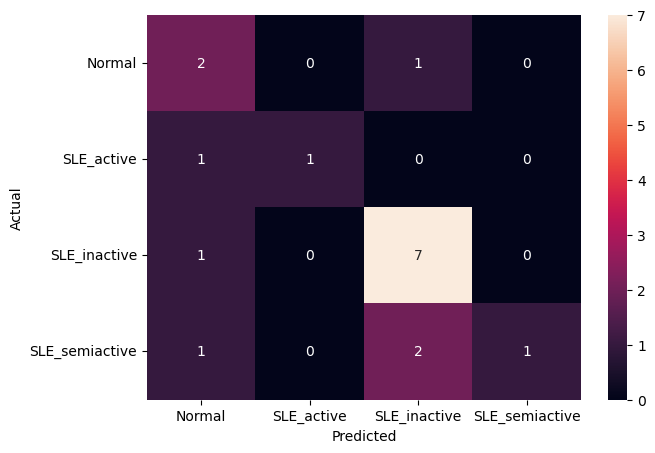

In [185]:
# Plotting the confusion matrix with the label name before encoding as the labels
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels = label_encoder.classes_, yticklabels = label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [186]:
# Printing the classification report
label_map = {i: label for i, label in enumerate(label_encoder.classes_)} # Encoding back to original labels
y_pred_labels = [label_map[pred] for pred in y_pred]
y_test_labels = [label_map[true] for true in y_test]

report = classification_report(y_test_labels, y_pred_labels)
print("Classification Report:")
print(report)

Classification Report:
                precision    recall  f1-score   support

        Normal       0.40      0.67      0.50         3
    SLE_active       1.00      0.50      0.67         2
  SLE_inactive       0.70      0.88      0.78         8
SLE_semiactive       1.00      0.25      0.40         4

      accuracy                           0.65        17
     macro avg       0.77      0.57      0.59        17
  weighted avg       0.75      0.65      0.63        17



In [187]:
# Extract true negatives (TN), false positives (FP), false negatives (FN), and true positives (TP) to calculate specificity
precision, recall, fscore, support = precision_recall_fscore_support(y_test_labels, y_pred_labels)
TN = support[0] - fscore[0]
FP = support[1] - fscore[1]
FN = support[0] - fscore[0]
TP = support[1] - fscore[1]

specificity = TN / (TN + FP)

print("Specificity:", specificity)

Specificity: 0.6521739130434783


The voting classifier model achieved an accuracy of approximately 64.71% on the given dataset. This means that the model was able to correctly classify about 65% of the samples.

Label "Normal":  
Precision: 40% - Out of all samples predicted as "Normal," only 40% were actually correct.  
Recall: 67% - The model was able to identify 67% of the actual "Normal" samples.  
F1-score: 50% - The harmonic mean of precision and recall for the "Normal" class is 50%.  

Label "SLE_active":  
Precision: 100% - The model achieved perfect precision for predicting "SLE_active" class.  
Recall: 50% - Only half of the actual "SLE_active" samples were correctly identified by the model.  
F1-score: 67% - The F1-score for the "SLE_active" class is 67%.  

Label "SLE_inactive":  
Precision: 70% - 70% of the samples predicted as "SLE_inactive" were actually correct.  
Recall: 88% - The model successfully identified 88% of the actual "SLE_inactive" samples.  
F1-score: 78% - The F1-score for the "SLE_inactive" class is 78%.  

Label "SLE_semiactive":  
Precision: 100% - The model achieved perfect precision for predicting "SLE_semiactive" class.  
Recall: 25% - Only a quarter of the actual "SLE_semiactive" samples were correctly identified by the model.  
F1-score: 40% - The F1-score for the "SLE_semiactive" class is 40%.  